<a href="https://colab.research.google.com/github/LucieEngel/Pneumonia-classifier/blob/main/Pnemonia_classifier_github.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Pneumonia - classifier from chest X-rays

Import packages

In [1]:
import os, warnings
import matplotlib.pyplot as plt
from matplotlib import gridspec
import pandas as pd
from PIL import Image
from matplotlib.pyplot import imshow
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [2]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [3]:
# Connect to my drive 

from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
# Change current directory 
os.chdir("drive/My Drive/Colab Notebooks")

## Step 1 : Load data

In [5]:
# Read dataset summary

pd.read_csv('archive/Chest_xray_Corona_dataset_Summary.csv', index_col=0)

,Label,Label_1_Virus_category,Label_2_Virus_category,Image_Count
0,Normal,NaN,NaN,1576
1,Pnemonia,Stress-Smoking,ARDS,2
2,Pnemonia,Virus,NaN,1493
3,Pnemonia,Virus,COVID-19,58
4,Pnemonia,Virus,SARS,4
5,Pnemonia,bacteria,NaN,2772
6,Pnemonia,bacteria,Streptococcus,5


In [6]:
# Read meta data 

meta_data = pd.read_csv('archive/Chest_xray_Corona_Metadata.csv', index_col=0)
meta_data

,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
0,IM-0128-0001.jpeg,Normal,TRAIN,NaN,NaN
1,IM-0127-0001.jpeg,Normal,TRAIN,NaN,NaN
2,IM-0125-0001.jpeg,Normal,TRAIN,NaN,NaN
3,IM-0122-0001.jpeg,Normal,TRAIN,NaN,NaN
4,IM-0119-0001.jpeg,Normal,TRAIN,NaN,NaN
...,...,...,...,...,...
5928,person1637_virus_2834.jpeg,Pnemonia,TEST,NaN,Virus
5929,person1635_virus_2831.jpeg,Pnemonia,TEST,NaN,Virus
5930,person1634_virus_2830.jpeg,Pnemonia,TEST,NaN,Virus
5931,person1633_virus_2829.jpeg,Pnemonia,TEST,NaN,Virus


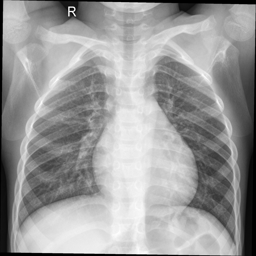

In [ ]:
# Show healthy chest X-rays

healthy = Image.open('archive/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/NORMAL2-IM-0539-0001.jpeg')
healthy.resize((256,256))

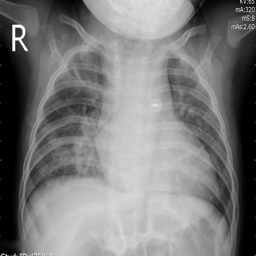

In [ ]:
# Show ill chest X-rays

ill = Image.open('archive/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/test/person1635_virus_2831.jpeg')
ill.resize((256,256))

In [ ]:
# Count images in training and testing datasets

meta_data.Dataset_type.value_counts()

TRAIN    5286
TEST      624
Name: Dataset_type, dtype: int64

In [ ]:
# Check proportion of patients with pnemonia in the TRAIN dataset
 
len(meta_data[(meta_data.Dataset_type == 'TRAIN') & (meta_data.Label == 'Pnemonia')])/len(meta_data[(meta_data.Dataset_type == 'TRAIN')])

0.7461218312523648

The dataset is hence highly unbalanced between healthy and ill patients. 74% of the dataset are X-rays with pnemonia.

In [7]:
# Define training and validation dataframes

TRAIN = meta_data.loc[meta_data.Dataset_type=="TRAIN"]
valdf = TRAIN.sample(frac=0.2)
traindf = TRAIN[~TRAIN.index.isin(valdf.index)].sample(frac=1)

We keep **20 % of our training set for validation**. Both training and validation sets are shuffled to avoid any kind of bais. 

In [8]:
# Check dimensions

len(valdf)+len(traindf)==len(TRAIN)

True

In [9]:
# Define testing dataframe similarly

testdf = meta_data.loc[meta_data.Dataset_type=="TEST"].sample(frac=1)

In [10]:
from keras_preprocessing.image import ImageDataGenerator

# Train generator

train_datagen = ImageDataGenerator(rescale = 1./255.)

train_generator = train_datagen.flow_from_dataframe(
    dataframe = traindf,
    directory = 'archive/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train',
    x_col = 'X_ray_image_name',
    y_col = 'Label',
    batch_size = 32,
    seed = 42, 
    #shuffle = True,
    classes=['Normal', 'Pnemonia'],
    class_mode='binary',
    target_size = (256, 256))


# Validation generator 

val_datagen = ImageDataGenerator(rescale = 1./255.)

valid_generator = val_datagen.flow_from_dataframe(
    dataframe = valdf,
    directory = 'archive/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train',
    x_col = 'X_ray_image_name',
    y_col = 'Label',
    batch_size = 16,
    seed = 42,
    #shuffle = True,
    classes=['Normal', 'Pnemonia'],
    class_mode='binary',
    target_size = (256, 256))

# Test generator

test_datagen = ImageDataGenerator(rescale = 1./255.)

test_generator = test_datagen.flow_from_dataframe(
    dataframe = testdf,
    directory = 'archive/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/test',
    x_col = 'X_ray_image_name',
    y_col = 'Label',
    batch_size = 32,
    seed = 42, 
    shuffle = True,
    classes=['Normal', 'Pnemonia'],
    class_mode='binary',
    target_size = (256, 256))

Found 4229 validated image filenames belonging to 2 classes.
Found 1057 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.


In [11]:
test_generator.class_indices

{'Normal': 0, 'Pnemonia': 1}

##Step 2 : Models 

In [37]:
from tensorflow import keras
from tensorflow.keras import layers

###Model 1 : use transfer learning with Resnet50

####Define model


In [ ]:
# Load pre-trained base : Resnet50, without the fully-connected layer at the top, with the weights when trained on ImageNet

input_t = tf.keras.Input(shape=(256,256,3))
pretrained_base = tf.keras.applications.ResNet50(include_top = False, weights = 'imagenet', input_tensor= input_t)

In [ ]:
# Set this pre-trained base to be trainable

pretrained_base.trainable = True

In [ ]:
# Add to this pre-trained base a filly-connected layer that will classify the features extracted by the Resnet50

model = keras.Sequential([
    pretrained_base,
    layers.Flatten(),
    layers.Dropout(0.3, input_shape=(10,)),
    layers.Dense(10, activation='relu'),
    layers.Dense(1, activation='sigmoid'),
])

In [ ]:
# Summary of trainable and non-trainable layers 

for i, layer in enumerate(model.layers):
  print(i,layer.name,"-",layer.trainable)

0 resnet50 - True
1 flatten_4 - True
2 dropout_4 - True
3 dense_8 - True
4 dense_9 - True


In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 flatten_4 (Flatten)         (None, 131072)            0         
                                                                 
 dropout_4 (Dropout)         (None, 131072)            0         
                                                                 
 dense_8 (Dense)             (None, 10)                1310730   
                                                                 
 dense_9 (Dense)             (None, 1)                 11        
                                                                 
Total params: 24,898,453
Trainable params: 24,845,333
Non-trainable params: 53,120
_________________________________________________________________


In [24]:
# Define AUC metric 

auc = tf.keras.metrics.AUC(
    num_thresholds=200, curve='ROC',
    summation_method='interpolation', name=None, dtype=None,
    thresholds=None, multi_label=False, num_labels=None, label_weights=None,
    from_logits=False
)

In [ ]:
# Compile model 

with tf.device('/device:GPU:0'):
  model.compile(
      optimizer=tf.keras.optimizers.Adam(epsilon=1e-5),
      loss = 'binary_crossentropy',
      metrics = ['accuracy',auc],
  )

I chose a small learning rate so as not to alter the pre-learned weights too much. 


####Train Model

In [ ]:
# Train model with GPU 

with tf.device('/device:GPU:0'):
  history = model.fit(
      train_generator,
      validation_data=valid_generator,
      epochs=50,
  )

Epoch 1/50
133/133 [==============================] - 1739s 13s/step - loss: 0.5859 - accuracy: 0.8749 - auc_3: 0.9088 - val_loss: 3.8887 - val_accuracy: 0.7512 - val_auc_3: 0.5000
Epoch 2/50
133/133 [==============================] - 133s 1s/step - loss: 0.2777 - accuracy: 0.9090 - auc_3: 0.9490 - val_loss: 0.5971 - val_accuracy: 0.7512 - val_auc_3: 0.7525
Epoch 3/50
133/133 [==============================] - 133s 996ms/step - loss: 0.2023 - accuracy: 0.9612 - auc_3: 0.9783 - val_loss: 1.1617 - val_accuracy: 0.7512 - val_auc_3: 0.6031
Epoch 4/50
133/133 [==============================] - 133s 996ms/step - loss: 0.2525 - accuracy: 0.9312 - auc_3: 0.9491 - val_loss: 2.0154 - val_accuracy: 0.7512 - val_auc_3: 0.4944
Epoch 5/50
133/133 [==============================] - 133s 996ms/step - loss: 0.2255 - accuracy: 0.9336 - auc_3: 0.9523 - val_loss: 0.8232 - val_accuracy: 0.2488 - val_auc_3: 0.5000
Epoch 6/50
133/133 [==============================] - 132s 994ms/step - loss: 0.2257 - accurac

#### Evaluate model 

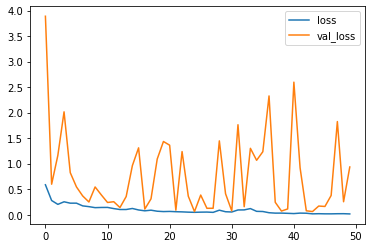

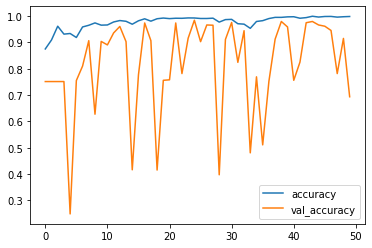

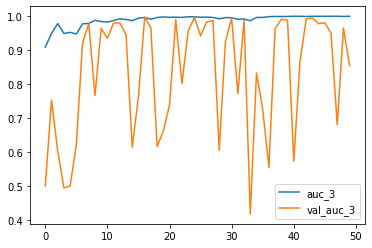

In [ ]:
# Plot loss, val_loss, accuracy and val_accuracy 

history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot()
history_frame.loc[:, ['auc_3', 'val_auc_3']].plot()

From these curves, we can see that the training phase is very unstable : this model is hence not adapted to our problem. Let's try to design a simpler CNN.

### Hand made model : work in progress

In [29]:
# Define parameters 

input_shape = (256, 256, 3)
classes  = 2
epochs = 20
batch_size = 32

In [31]:
callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [44]:
from keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D,Activation, Dropout, BatchNormalization, Flatten, Dense, AvgPool2D,MaxPool2D
model_hm_2 = keras.Sequential()
model_hm_2.add(Conv2D(32, (3, 3), input_shape=input_shape))
model_hm_2.add(Activation('relu'))
model_hm_2.add(MaxPooling2D(pool_size=(2, 2)))

model_hm_2.add(Conv2D(32, (3, 3)))
model_hm_2.add(Activation('relu'))
model_hm_2.add(MaxPooling2D(pool_size=(2, 2)))


model_hm_2.add(Conv2D(64,(3,3)))
model_hm_2.add(Activation("relu"))
model_hm_2.add(Conv2D(250,(3,3)))
model_hm_2.add(Activation("relu"))
  
model_hm_2.add(Conv2D(128,(3,3)))
model_hm_2.add(Activation("relu"))
model_hm_2.add(AvgPool2D(2,2))
model_hm_2.add(Conv2D(64,(3,3)))
model_hm_2.add(Activation("relu"))
model_hm_2.add(AvgPool2D(2,2))

model_hm_2.add(Conv2D(256,(2,2)))
model_hm_2.add(Activation("relu"))
model_hm_2.add(MaxPool2D(2,2))
    
model_hm_2.add(Flatten())
model_hm_2.add(Dense(32))
model_hm_2.add(Dropout(0.25))
model_hm_2.add(Dense(1))
model_hm_2.add(Activation("sigmoid"))

In [49]:
model_hm_2.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 activation_8 (Activation)   (None, 254, 254, 32)      0         
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 127, 127, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 125, 125, 32)      9248      
                                                                 
 activation_9 (Activation)   (None, 125, 125, 32)      0         
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 62, 62, 32)       0         
 g2D)                                                 

In [45]:
with tf.device('/device:GPU:0'):
  model_hm_2.compile(
      optimizer=tf.keras.optimizers.Adam(epsilon=1e-2),
      loss = 'binary_crossentropy',
      metrics = ['accuracy',auc],
  )

In [46]:
with tf.device('/device:GPU:0'):
  history_hm_2 = model_hm_2.fit(
      train_generator,
      validation_data=valid_generator,
      epochs=epochs,
      callbacks = [callbacks]
  )

Epoch 1/20
133/133 [==============================] - 79s 589ms/step - loss: 0.5793 - accuracy: 0.7463 - auc: 0.5313 - val_loss: 0.5481 - val_accuracy: 0.7455 - val_auc: 0.7885
Epoch 2/20
133/133 [==============================] - 77s 580ms/step - loss: 0.4224 - accuracy: 0.8089 - auc: 0.8234 - val_loss: 0.3487 - val_accuracy: 0.8269 - val_auc: 0.9518
Epoch 3/20
133/133 [==============================] - 77s 579ms/step - loss: 0.2486 - accuracy: 0.9068 - auc: 0.9485 - val_loss: 0.1876 - val_accuracy: 0.9139 - val_auc: 0.9730
Epoch 4/20
133/133 [==============================] - 78s 583ms/step - loss: 0.1831 - accuracy: 0.9340 - auc: 0.9716 - val_loss: 0.1408 - val_accuracy: 0.9404 - val_auc: 0.9837
Epoch 5/20
133/133 [==============================] - 78s 587ms/step - loss: 0.1484 - accuracy: 0.9485 - auc: 0.9806 - val_loss: 0.1156 - val_accuracy: 0.9546 - val_auc: 0.9910
Epoch 6/20
133/133 [==============================] - 76s 574ms/step - loss: 0.1320 - accuracy: 0.9520 - auc: 0.984

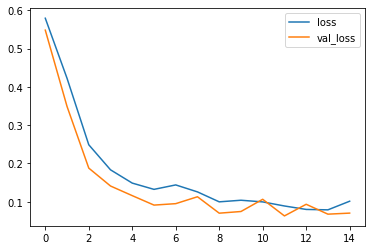

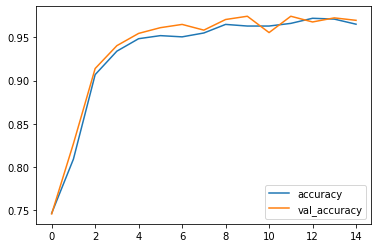

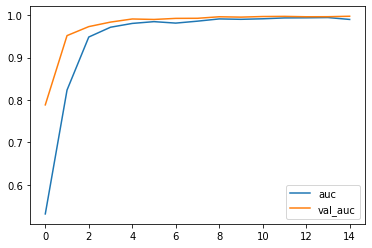

In [47]:
# Plot loss, val_loss, accuracy and val_accuracy 

history_hm_2_frame = pd.DataFrame(history_hm_2.history)
history_hm_2_frame.loc[:, ['loss', 'val_loss']].plot()
history_hm_2_frame.loc[:, ['accuracy', 'val_accuracy']].plot()
history_hm_2_frame.loc[:, ['auc', 'val_auc']].plot()

In [48]:
# Evaluate model 

evaluate_hm_2 = model_hm_2.evaluate(test_generator, verbose=1)

20/20 [==============================] - 126s 7s/step - loss: 0.7418 - accuracy: 0.7837 - auc: 0.8898


In [ ]:
# Find the best threshold (the threshold that maximises precision and recall)

def find_optimal_threshold(precision, recall, threshold):
    f1_score = (2 * precision * recall) / (precision + recall)
    best_idx = np.argmax(f1_score)
    best_threshold = threshold[best_idx]
    return best_threshold, best_idx

y_true = test_generator.classes
y_predict = model_hm_2.predict(test_generator)
precision, recall, threshold = precision_recall_curve(y_true, y_predict)
best_threshold, best_idx = find_optimal_threshold(precision, recall, threshold)
print('Best threshold: {}'.format(best_threshold))

In [ ]:
# Plot Precision-Recall curve

plt.figure(figsize=(7, 5))
auc_score = auc(recall, precision)
plt.plot([1, 0], [0, 1], linestyle='--', color='black', label='No skill')
plt.plot(recall, precision, linewidth=3, label='ResNet50')
plt.plot(recall[best_idx], precision[best_idx], 
         marker='o', color='black', 
         label='Best_theshold', linestyle='', markersize='7')
plt.xlabel('Recall', size=13)
plt.ylabel('Precision', size=13)
plt.title('Precision-Recall curve (AUC - {:.4f})'.format(auc_score), size=15)
plt.legend()
plt.show()